In [2]:
import numpy as np
import matplotlib.pyplot as plt
from core.activations import Fun
from core.losses import LossFun, mse
from core.mlp import MLP
from data.regression import get_regression_data, Size, RegressionType
from utils.normalize import normalize
from utils.split import split_data


In [3]:
import numpy as np

np.random.seed(42)

In [29]:
from collections import defaultdict

hidden_layers_num = [1, 2, 3]
hidden_layers_size = [16, 32, 64]
activations = [Fun.ReLU, Fun.Tanh, Fun.Sigmoid]
task_types = [RegressionType.CUBE, RegressionType.MULTIMODAL, RegressionType.ACTIVATION]
task_size = Size._100
epochs = 3000
learning_rate = 0.01

results = defaultdict(dict)

In [ ]:
import itertools

for task_type in task_types:
    X, Y = get_regression_data(task_type, task_size)
    Xn, X_mean, X_std = normalize(X)
    Yn, Y_mean, Y_std = normalize(Y)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(Xn, Yn)
    for hl_num in hidden_layers_num:
        for layer_sizes in itertools.product(hidden_layers_size, repeat=hl_num):
            for layer_activations in activations:
                
                layer_sizes_full = [1] + list(layer_sizes) + [1]
                activations_full = [layer_activations] * hl_num + [Fun.Linear]
                mlp = MLP(layer_sizes_full, activations_full, LossFun.MSE)

                train_loss, val_loss, _ = mlp.train(X_train, y_train, X_val, y_val, epochs=epochs, learning_rate=learning_rate)

                test_predictions = mlp.forward(X_test)
                test_loss = mse(test_predictions, y_test)

                config_key = f"{list(layer_sizes)}, {layer_activations.name}"
                
                results[task_type][config_key] = {
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "test_loss": test_loss
                }
                print(f"Completed: {config_key} with Test Loss: {test_loss}")

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def analyze_results(results):
    """
    Analiza wpływu liczby warstw i liczby neuronów na wyniki testowe.
    """
    for task_type, configs in results.items():
        data = []

        # --- Parsowanie konfiguracji ---
        for config_key, metrics in configs.items():
            # np. "[16, 32], ReLU" -> interesuje nas tylko lista warstw
            try:
                layers_str = config_key.split("],")[0] + "]"
                layers = eval(layers_str)
            except Exception as e:
                print(f"Warning: could not parse key {config_key} ({e})")
                continue

            data.append({
                "num_layers": len(layers),
                "mean_layer_size": np.mean(layers),
                "test_loss": metrics["test_loss"]
            })

        if not data:
            print(f"No data for {task_type}")
            continue

        # --- 1. Wpływ liczby warstw ---
        plt.figure(figsize=(6,4))
        by_layers = {}
        for d in data:
            by_layers.setdefault(d["num_layers"], []).append(d["test_loss"])
        layers = sorted(by_layers.keys())
        plt.plot(layers, [np.mean(by_layers[l]) for l in layers], marker="o", color="tab:blue")
        plt.title(f"{task_type.name} — wpływ liczby warstw na Test Loss")
        plt.xlabel("Liczba warstw ukrytych")
        plt.ylabel("Średni Test Loss")
        plt.grid(True)
        plt.show()

        # --- 2. Wpływ rozmiaru warstw ---
        plt.figure(figsize=(6,4))
        plt.scatter([d["mean_layer_size"] for d in data],
                    [d["test_loss"] for d in data],
                    c="tab:green", alpha=0.7)
        plt.title(f"{task_type.name} — wpływ rozmiaru warstw na Test Loss")
        plt.xlabel("Średnia liczba neuronów w warstwie")
        plt.ylabel("Test Loss")
        plt.grid(True)
        plt.show()

        # --- 3. Heatmapa liczba warstw × rozmiar warstw ---
        num_layers_unique = sorted(set(d["num_layers"] for d in data))
        mean_sizes_unique = sorted(set(int(round(d["mean_layer_size"])) for d in data))
        matrix = np.zeros((len(num_layers_unique), len(mean_sizes_unique)))

        for i, nl in enumerate(num_layers_unique):
            for j, ms in enumerate(mean_sizes_unique):
                vals = [d["test_loss"] for d in data 
                        if d["num_layers"] == nl and int(round(d["mean_layer_size"])) == ms]
                matrix[i, j] = np.mean(vals) if vals else np.nan

        plt.figure(figsize=(8,5))
        sns.heatmap(matrix, annot=True, fmt=".3f", cmap="viridis",
                    xticklabels=mean_sizes_unique, yticklabels=num_layers_unique)
        plt.title(f"{task_type.name} — Test Loss (liczba warstw × rozmiar warstwy)")
        plt.xlabel("Średnia liczba neuronów w warstwie")
        plt.ylabel("Liczba warstw ukrytych")
        plt.show()


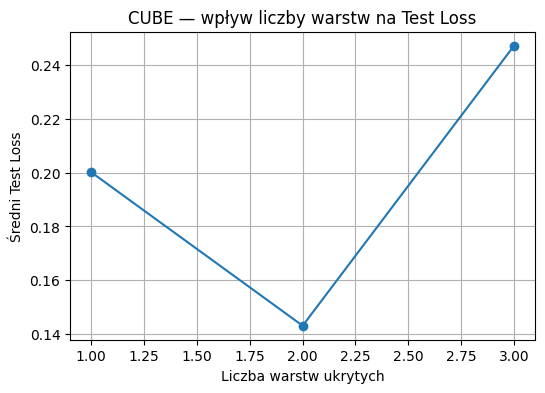

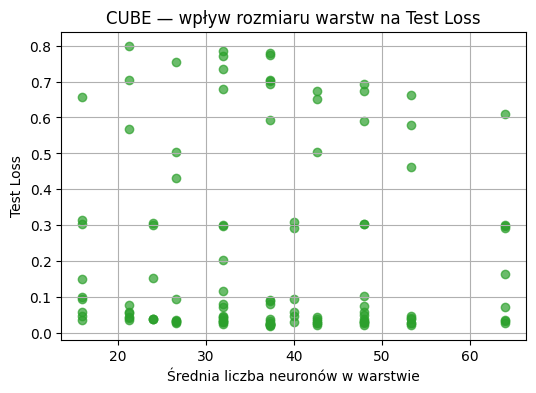

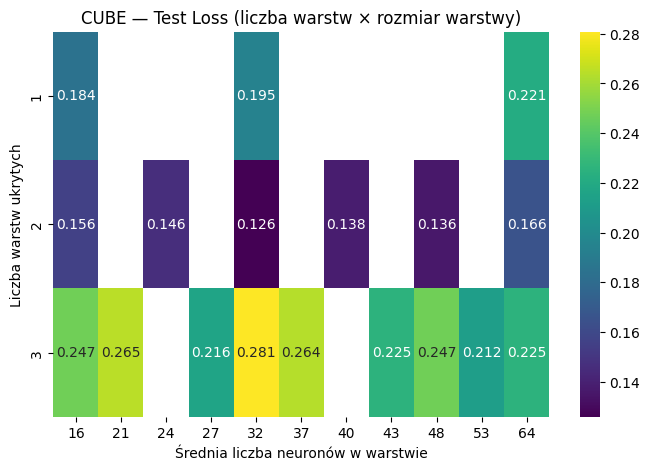

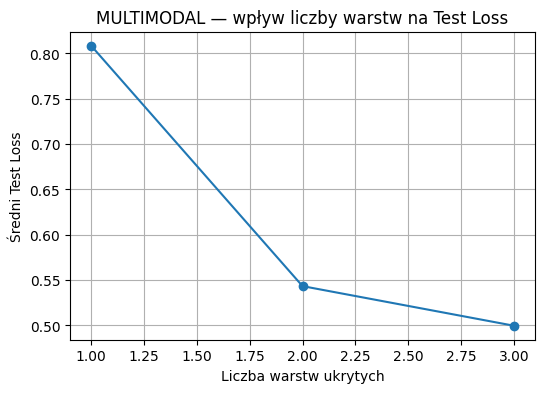

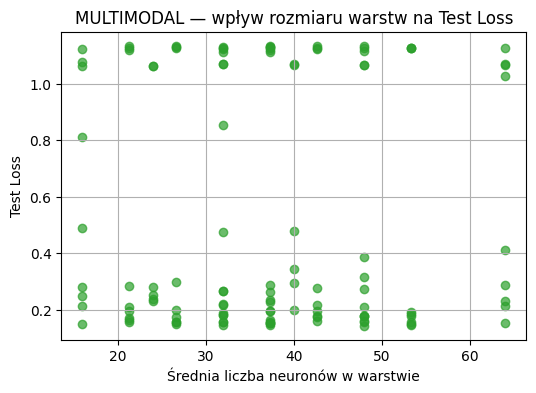

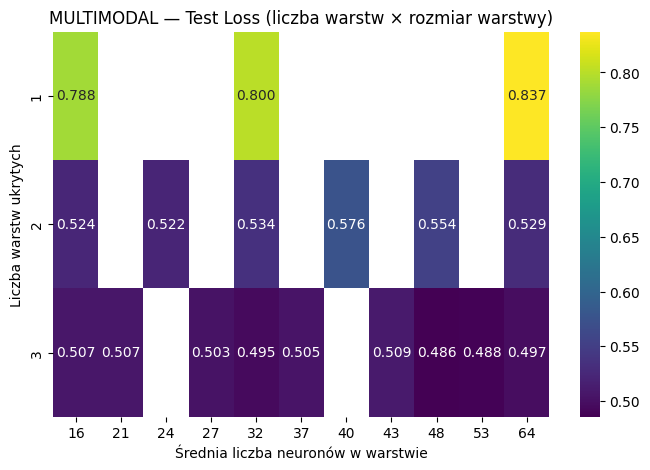

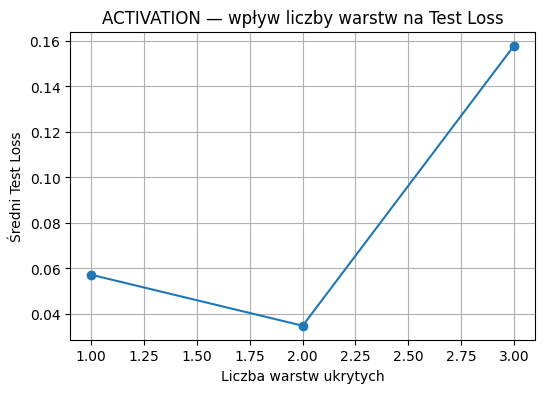

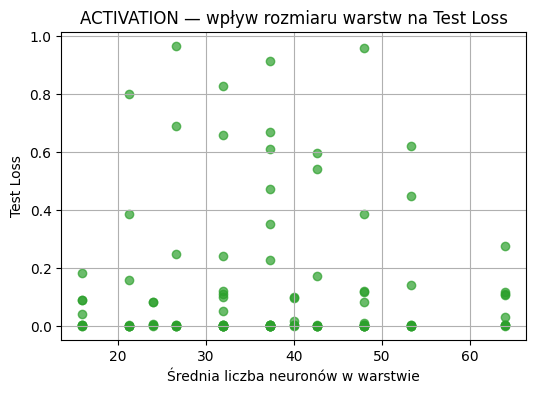

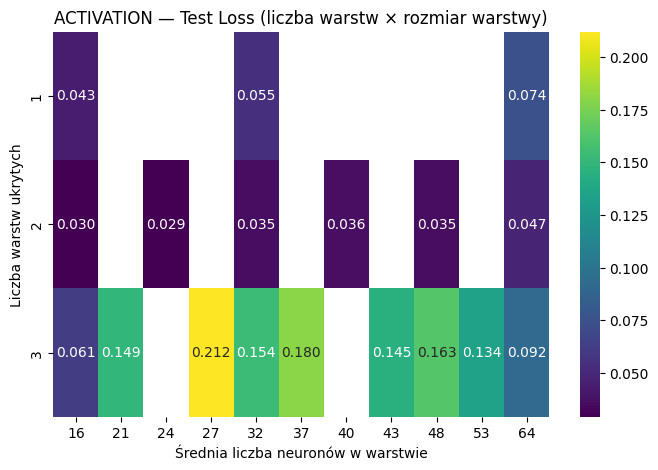

In [38]:
analyze_results(results)

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.lines import Line2D

def plot_validation_loss_by_activation(results):
    """
    Tworzy wykresy Validation Loss dla każdej funkcji aktywacji i typu zadania.
    Kolor odpowiada średniej liczbie neuronów, styl linii — liczbie warstw.
    Dodatkowo rysuje średnie przebiegi dla sieci 1, 2 i 3 warstwowych.
    """
    for task_type, configs in results.items():
        activations = sorted({cfg.split("],")[-1].strip().strip(",").strip() for cfg in configs.keys()})
        
        for activation in activations:
            plt.figure(figsize=(8, 5))
            
            # Zbierz dane do ustalenia zakresu kolorów
            mean_sizes = []
            for config_key in configs:
                if activation not in config_key:
                    continue
                try:
                    layers = eval(config_key.split("],")[0] + "]")
                    mean_sizes.append(np.mean(layers))
                except Exception:
                    pass
            
            if not mean_sizes:
                continue
            min_size, max_size = min(mean_sizes), max(mean_sizes)
            norm = plt.Normalize(min_size, max_size)
            cmap = cm.viridis

            # --- Rysowanie poszczególnych sieci ---
            val_loss_by_layers = {1: [], 2: [], 3: []}  # do średnich
            max_epochs = 0

            for config_key, metrics in configs.items():
                if activation not in config_key:
                    continue

                # Parsowanie konfiguracji
                try:
                    layers = eval(config_key.split("],")[0] + "]")
                    num_layers = len(layers)
                    mean_size = np.mean(layers)
                except Exception:
                    continue

                val_loss = metrics.get("val_loss", None)
                if val_loss is None or not isinstance(val_loss, (list, np.ndarray)):
                    continue

                epochs = np.arange(1, len(val_loss) + 1)
                max_epochs = max(max_epochs, len(val_loss))

                # Kolor = średni rozmiar warstwy
                color = cmap(norm(mean_size))

                # Styl = liczba warstw
                if num_layers == 1:
                    linestyle = "-"
                elif num_layers == 2:
                    linestyle = "--"
                elif num_layers == 3:
                    linestyle = ":"
                else:
                    linestyle = "-."

                plt.plot(
                    epochs, val_loss,
                    color=color,
                    linestyle=linestyle,
                    alpha=0.3,
                    linewidth=1.2
                )

                # Zapisz do średnich
                if num_layers in val_loss_by_layers:
                    val_loss_by_layers[num_layers].append(val_loss)

            # --- Rysowanie średnich przebiegów ---
            for num_layers, losses_list in val_loss_by_layers.items():
                if not losses_list:
                    continue
                # Uzupełnij wszystkie listy do max_epochs
                losses_matrix = np.array([np.pad(l, (0, max_epochs - len(l)), constant_values=np.nan)
                                          for l in losses_list])
                mean_loss = np.nanmean(losses_matrix, axis=0)
                # Gruba czarna linia
                if num_layers == 1:
                    linestyle = "-"
                elif num_layers == 2:
                    linestyle = "--"
                else:  # 3
                    linestyle = ":"
                plt.plot(
                    np.arange(1, max_epochs + 1),
                    mean_loss,
                    # color="black",
                    linestyle=linestyle,
                    linewidth=2.5,
                    label=f"Średnia {num_layers} warstw"
                )

            # Dodanie paska kolorów
            # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            # sm.set_array([])
            # cbar = plt.colorbar(sm, pad=0.02)
            # cbar.set_label("Średnia liczba neuronów w warstwie")

            # Legenda stylu linii dla średnich
            plt.legend(fontsize=8)
            plt.title(f"{task_type.name} — Validation Loss ({activation})")
            plt.xlabel("Epoka")
            plt.ylabel("Validation Loss")
            plt.grid(True, linestyle="--", alpha=0.5)
            plt.tight_layout()
            plt.yscale("log")
            plt.show()


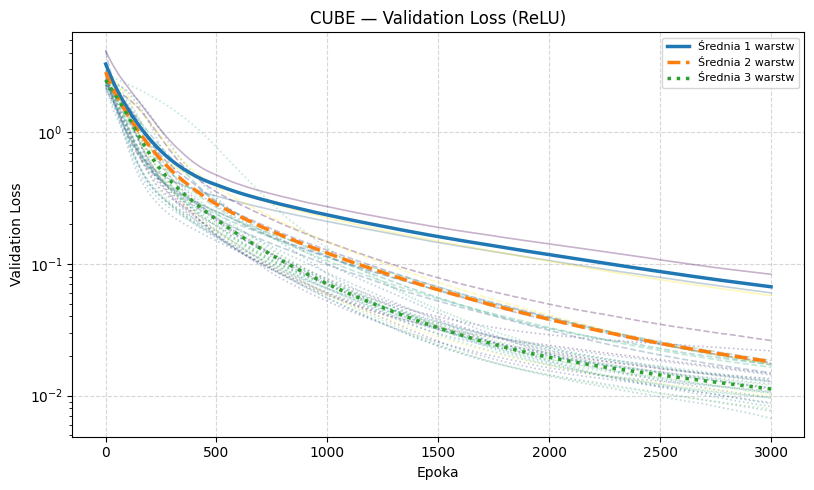

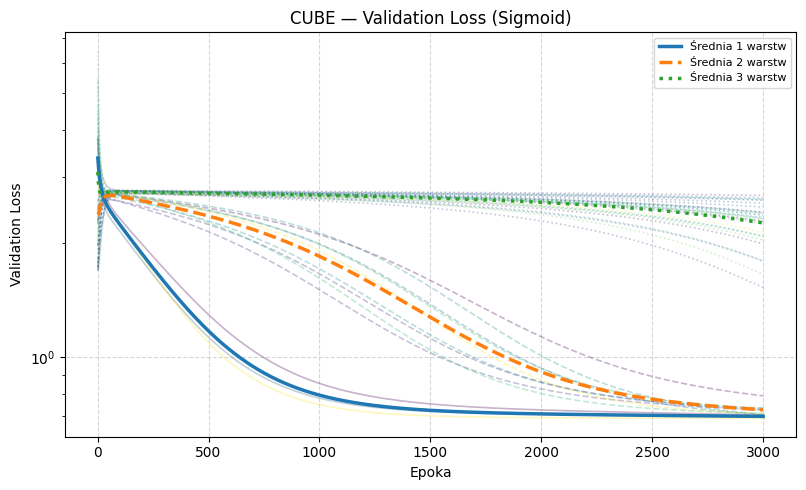

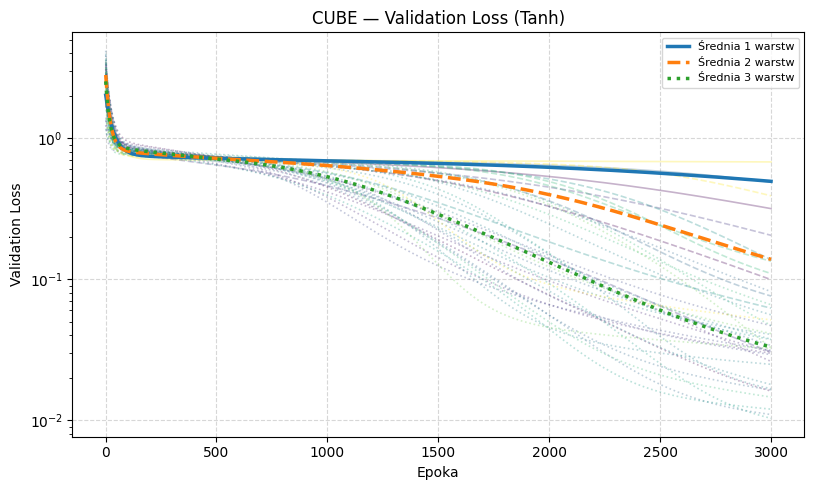

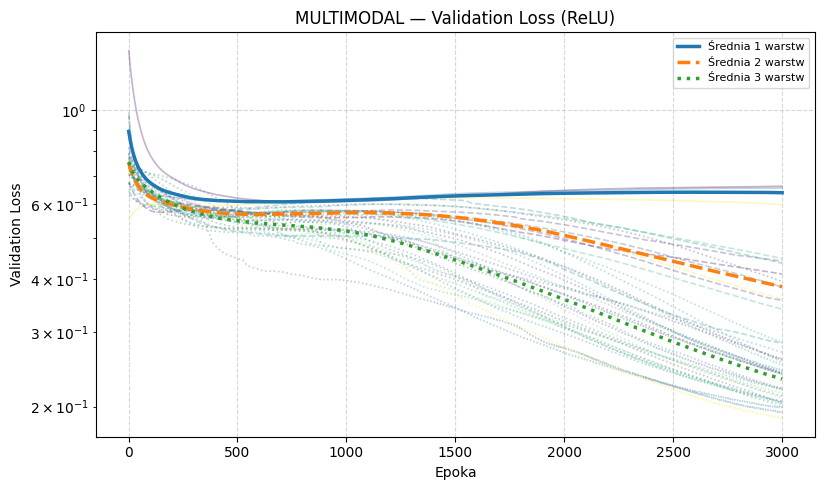

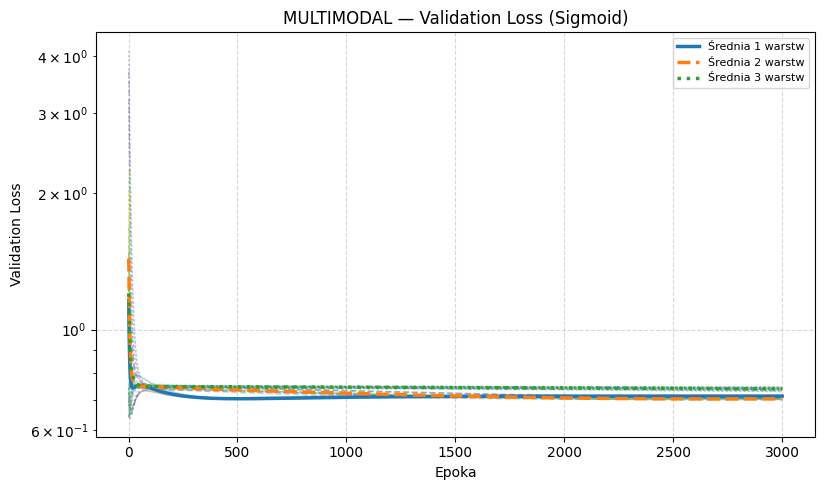

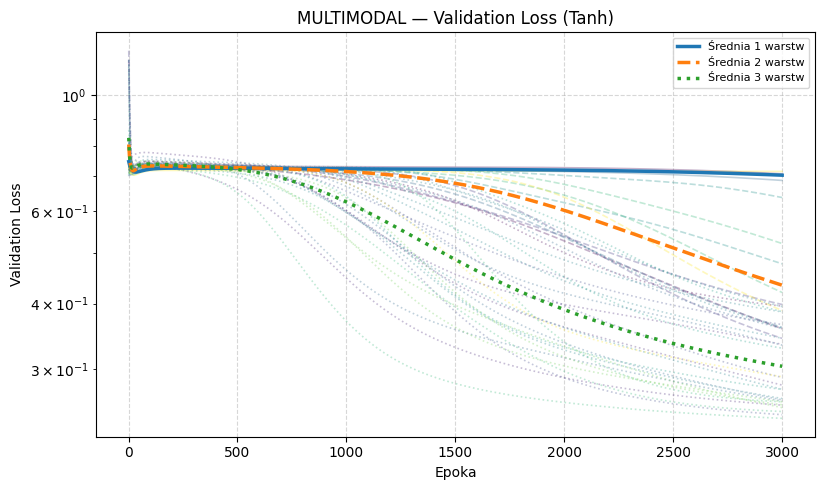

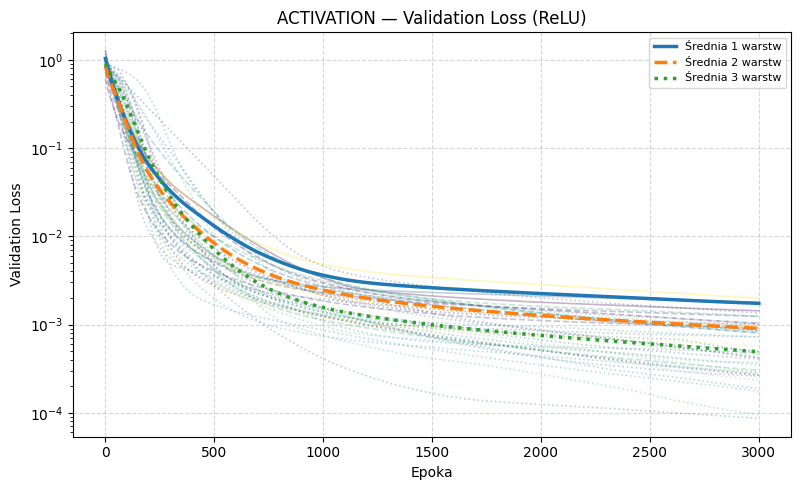

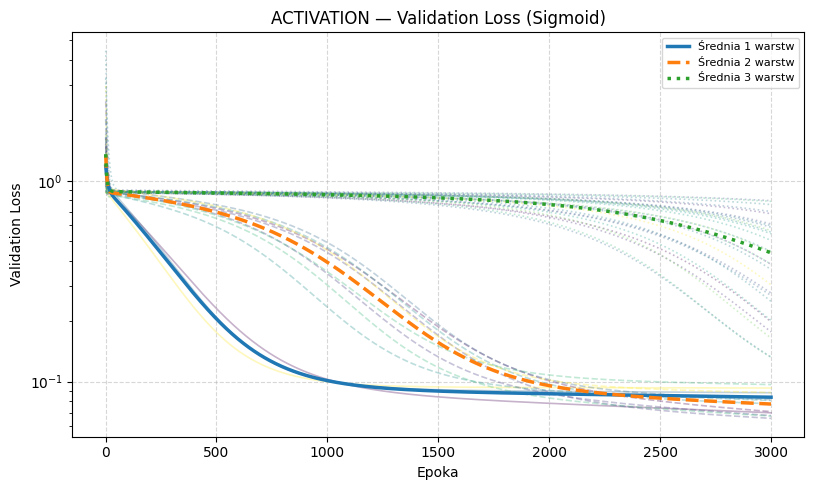

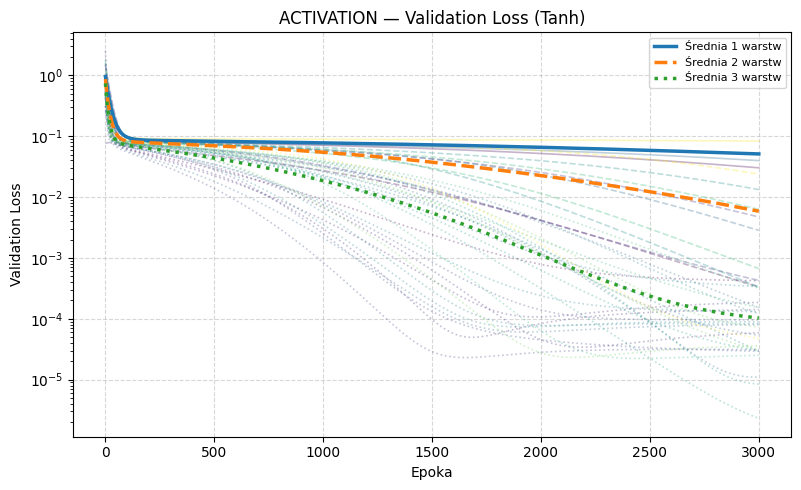

In [64]:
plot_validation_loss_by_activation(results)